# How Do Skip Connections Work?


The concept of skip connections was first introduced by He et. al (2015) along with the ResNet architecture. This built upon the concept of highway networks, which allowed gated connections between layers. These breakthroughs made it possible to train much deeper networks with 100s of layers.

A 'skip connection' simply means that the input of the current layer or block of layers is added back to the output of the block.

$$
x' = x + f(x)
$$


However, it wasn't till 2018 (Li et. al) that it was understood why this improvement helped train deep networks.
So why does this work? To understand we will train two deep CNNs, each with 50 layers. The second (candidate) model will implement skip connections after each CNN filter.





## Let's Start by Looking at our Dataset


The CIFAR-10 dataset is a popular benchmark for machine learning and computer vision tasks, consisting of 60,000 32x32 color images across 10 distinct classes. Each image is labeled as one of the following categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck. The dataset is divided into 50,000 training images and 10,000 test images, with an even distribution of 6,000 images per class.

Despite its simplicity, the dataset contains a variety of object poses, lighting conditions, and backgrounds, making it non-trivial to achieve high accuracy.


Convolutional Neural Networks and other image-specific architectures are typically trained on this dataset. However, for this experiment, we will use a feedforward network in order to demonstrate the benefits of using dropout.

In [1]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

train_tf, test_tf = tfds.load('cifar10', split=['train', 'test'], batch_size=-1, as_supervised=True)

raw_train_images, train_labels = train_tf[0], train_tf[1]
raw_train_images = jnp.float32(raw_train_images)
raw_train_images = raw_train_images.reshape((raw_train_images.shape[0], -1))
train_labels = jnp.float32(train_labels)

raw_test_images, test_labels = test_tf[0], test_tf[1]
raw_test_images = jnp.float32(raw_test_images)
raw_test_images = raw_test_images.reshape((raw_test_images.shape[0], -1))
test_labels = jnp.float32(test_labels)

print(f"Training Set Size {raw_train_images.shape[0]}")
print(f"Test Set Size {raw_test_images.shape[0]}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.1KAXMD_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.1KAXMD_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Training Set Size 50000
Test Set Size 10000


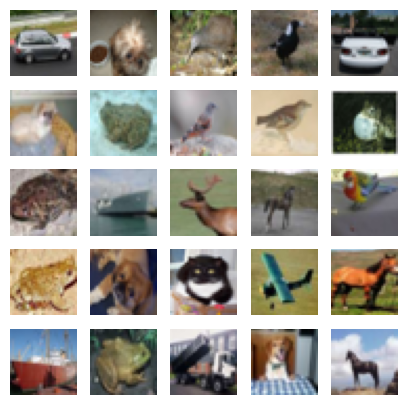

In [2]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-v0_8-darkgrid')

RANDOM_KEY = 42

num_examples = 25
row_size = int(math.sqrt(num_examples))
fig, axs = plt.subplots(row_size, row_size, figsize=(row_size,row_size))

rng = jax.random.PRNGKey(RANDOM_KEY)
idxs = jax.random.randint(rng, (num_examples,), 0, raw_train_images.shape[0])
exs = raw_train_images[idxs,:].reshape((num_examples,32,32,3))/255.0

for ex in range(num_examples):
    i = ex // row_size
    j = ex % row_size
    axs[i,j].imshow(exs[ex])
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].set_xmargin(0)
    axs[i,j].set_ymargin(0)

plt.show()

## Let's train a ResNet (NoSkip) network on CIFAR 10

In [3]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.training import train_state
import tensorflow_datasets as tfds

### Simple CNN Model

In [4]:
# Define the CNN model
class SimpleCNN(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool, rng=rng):
        #print(x.shape)
        x = nn.Conv(features=32, kernel_size=(3, 3))(x) # padding defaults to "SAME"
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        #print(x.shape)
        #print('---')

        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        #print(x.shape)
        #print('===')

        x = x.reshape((x.shape[0], -1))  # Flatten the tensor
        #print(x.shape)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        #print(x.shape)
        x = nn.Dense(features=10)(x)  # 10 classes for CIFAR-10
        #print(x.shape)
        #print('ooo')
        return x

### Deep CNN Network

In [5]:
# Define the CNN model


class ConvBlock(nn.Module):

    stride: int
    filters: int

    @nn.compact
    def __call__(self, x, train):

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=self.stride, padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=1, padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        return nn.relu(x)


class DeepCNN(nn.Module):

    @nn.compact
    def __call__(self, x, train: bool):

        x = nn.Conv(features=16, kernel_size=(3, 3), strides=1, padding='SAME')(x)

        x = nn.BatchNorm(use_running_average=not train)(x)

        x = ConvBlock(stride=1, filters=16)(x, train)

        x = ConvBlock(stride=2, filters=32)(x, train)

        x = ConvBlock(stride=2, filters=64)(x, train)

        x = nn.avg_pool(x, window_shape=(x.shape[1], x.shape[2]))
        x = x.reshape((x.shape[0], -1))  # Flatten

        x = nn.Dense(features=10)(x)  # Output layer for 10 classes


        return x

### CNN with Residual Connection

In [8]:
# Define the CNN model

from flax.linen import Module

class ShortcutLayer(Module):

    stride: int
    planes: int  # Number of output channels after padding

    @staticmethod
    def pad_channels(x, target_planes):
        """Pad the channel dimension to match target_planes."""
        input_planes = x.shape[-1]
        pad_planes = target_planes - input_planes
        if pad_planes >= 0:
        # Compute padding for the channel dimension
          pad = [(0, 0), (0, 0), (0, 0), (pad_planes // 2, pad_planes - pad_planes // 2)]
          return jnp.pad(x, pad, mode='constant', constant_values=0)
        return x

    def __call__(self, x):
        # Downsample spatial dimensions by strided slicing
        x = x[:, ::self.stride, ::self.stride, :]
        # Pad channel dimensions to `planes`
        x = self.pad_channels(x, self.planes)
        return x


class ResidualBlock(nn.Module):

    stride: int
    filters: int

    @nn.compact
    def __call__(self, x, train):
        residual = x

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=self.stride, padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.relu(x)

        x = nn.Conv(features=self.filters, kernel_size=(3, 3), strides=1, padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)

        #if self.stride > 1:
          # Downsample for the residual connection
        residual = ShortcutLayer(self.stride, self.filters)(residual)

        return nn.relu(x + residual)


class ResidualCNN(nn.Module):

    @nn.compact
    def __call__(self, x, train: bool):

        x = nn.Conv(features=16, kernel_size=(3, 3), strides=1, padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)

        x = ResidualBlock(stride=1, filters=16)(x, train)

        x = ResidualBlock(stride=2, filters=32)(x, train)

        x = ResidualBlock(stride=2, filters=64)(x, train)

        x = nn.avg_pool(x, window_shape=(x.shape[1], x.shape[2]))
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=10)(x)  # Output layer for 10 classes

        return x

In [15]:
BATCH_SIZE = 128
LEARNING_RATE = 0.1
NUM_EPOCHS = 200


# Load CIFAR-10 dataset
def load_data():
    def preprocess_fn(batch):
        image = batch['image'] / 255.0  # Normalize images to [0, 1]
        label = batch['label']
        return image, label

    ds_train, ds_test = tfds.load(
        'cifar10', split=['train', 'test'], as_supervised=False, batch_size=-1
    )
    train_data = tfds.as_numpy(ds_train)
    test_data = tfds.as_numpy(ds_test)

    train_images, train_labels = preprocess_fn(train_data)
    test_images, test_labels = preprocess_fn(test_data)

    mean = jnp.mean(train_images)
    std = jnp.std(train_images)

    train_images = (train_images - mean) / std
    test_images = (test_images - mean) / std

    return train_images, train_labels, test_images, test_labels


# Create the train state
def create_train_state(rng, cnn, train_size, learning_rate):
    variables = cnn.init(rng, jnp.ones([1, 32, 32, 3]), True)
    params = variables['params']
    batch_stats = None
    if "batch_stats" in variables:
        batch_stats = variables['batch_stats']


    # Define a staggered learning rate schedule
    #def staggered_lr_schedule(step):
    #    # Use different learning rates for different step ranges
    #    if step < 20000:
    #        return 1e-1  # High learning rate for the initial phase
    #    elif step < 40000:
    #        return 1e-2  # Reduced learning rate
    #    else:
    #        return 1e-3  # Final fine-tuning phase

    # Wrap the staggered schedule in optax's piecewise_constant_schedule
    #learning_rate_schedule = optax.join_schedules(
    #    schedules=[
    #        optax.constant_schedule(1e-1),  # First phase
    #        optax.constant_schedule(1e-2),  # Second phase
    #        optax.constant_schedule(1e-3)   # Third phase
    #    ],
    #    boundaries=[20000, 40000]  # Steps to switch phases
    #)

    # Define a linear decay schedule
    initial_learning_rate = 1e-1  # Starting learning rate
    total_steps = NUM_EPOCHS * (train_size // BATCH_SIZE)  # Total number of training steps

    learning_rate_schedule = optax.linear_schedule(
        init_value=initial_learning_rate,  # Initial learning rate
        end_value=0.0,  # Final learning rate (decayed to 0)
        transition_steps=total_steps  # Steps over which decay occurs
    )

    # Configure the optimizer
    tx = optax.adam(learning_rate=learning_rate_schedule)

    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx), batch_stats


# Define the training and evaluation steps
@jax.jit
def train_step(state, batch, batch_stats):
    images, labels = batch

    def loss_fn(params, batch_stats):
        logits, outputs = state.apply_fn({'params': params, 'batch_stats': batch_stats}, images, train=True, mutable=["batch_stats"])

        updated_batch_stats = outputs['batch_stats']

        one_hot = jax.nn.one_hot(labels, num_classes=10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, one_hot))
        return loss, (updated_batch_stats, logits)



    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    outputs, grads = grad_fn(state.params, batch_stats)
    loss, aux  = outputs
    updated_batch_stats, logits = aux
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    grads_flat = jax.tree_util.tree_flatten(grads)[0][2]
    grad_norm = jnp.linalg.norm(grads_flat)
    state = state.apply_gradients(grads=grads)
    return state, loss, accuracy, updated_batch_stats


@jax.jit
def eval_step(state, batch, batch_stats):
    images, labels = batch
    logits = state.apply_fn({'params': state.params, 'batch_stats': batch_stats}, images, train=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy


# Training loop
def train_and_evaluate(model, num_epochs, batch_size, learning_rate):


    train_images, train_labels, test_images, test_labels = load_data()

    train_size = len(train_images)

    rng = jax.random.PRNGKey(0)

    # Create the train state
    state, batch_stats = create_train_state(rng, model, train_size, learning_rate)
    iter = 0
    # Prepare data batches
    for epoch in range(num_epochs):

        train_batches = zip(
            jnp.array_split(train_images, len(train_images) // batch_size),
            jnp.array_split(train_labels, len(train_labels) // batch_size),
        )
        test_batches = zip(
            jnp.array_split(test_images, len(test_images) // batch_size),
            jnp.array_split(test_labels, len(test_labels) // batch_size),
        )

        # Training
        train_losses = []
        train_accuracies = []
        for batch in train_batches:
            state, loss, accuracy, batch_stats = train_step(state, batch, batch_stats)
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            iter += 1

        # Evaluation
        test_accuracies = []
        for batch in test_batches:
            accuracy = eval_step(state, batch, batch_stats)
            test_accuracies.append(accuracy)

        # Compute mean loss
        mean_epoch_loss = jnp.mean(jnp.array(train_losses))
        # Compute mean accuracy
        train_accuracy = jnp.mean(jnp.array(train_accuracies))  # Convert to JAX array
        test_accuracy = jnp.mean(jnp.array(test_accuracies))  # Convert to JAX array
        print(f"Iter: {iter + 1}, Epoch {epoch + 1}, Train Loss: {mean_epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return state


# Run the training
model = ResidualCNN()
trained_state = train_and_evaluate(model=model, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)


Iter: 391, Epoch 1, Train Loss: 1.7238, Train Accuracy: 0.3578, Test Accuracy: 0.3139
Iter: 781, Epoch 2, Train Loss: 1.2899, Train Accuracy: 0.5305, Test Accuracy: 0.3535
Iter: 1171, Epoch 3, Train Loss: 1.1286, Train Accuracy: 0.5927, Test Accuracy: 0.4601
Iter: 1561, Epoch 4, Train Loss: 1.0253, Train Accuracy: 0.6343, Test Accuracy: 0.4527
Iter: 1951, Epoch 5, Train Loss: 0.9568, Train Accuracy: 0.6574, Test Accuracy: 0.4184
Iter: 2341, Epoch 6, Train Loss: 0.9064, Train Accuracy: 0.6776, Test Accuracy: 0.5655
Iter: 2731, Epoch 7, Train Loss: 0.8638, Train Accuracy: 0.6921, Test Accuracy: 0.5766
Iter: 3121, Epoch 8, Train Loss: 0.8272, Train Accuracy: 0.7064, Test Accuracy: 0.5470
Iter: 3511, Epoch 9, Train Loss: 0.7966, Train Accuracy: 0.7182, Test Accuracy: 0.5942
Iter: 3901, Epoch 10, Train Loss: 0.7713, Train Accuracy: 0.7282, Test Accuracy: 0.5856
Iter: 4291, Epoch 11, Train Loss: 0.7484, Train Accuracy: 0.7353, Test Accuracy: 0.6092
Iter: 4681, Epoch 12, Train Loss: 0.7292, T

| Model        | Conv Layers  | Acc. (200 epochs) | Acc. (50 epochs) | Acc. (100 epochs) |
|--------------|--------------|--------------|-----  -|------|
| SimpleCNN    | 2            |              |        |.     |.  
| DeepCNN      | 15           | 85.91        |        |.     |
| DeepCNN      | 20           | 85.59        | 80.27. |83.22 |
| DeepCNN.     | 25.          | 85.21        | 81.45  |83.25 |
| ResCNN       | 20           |              |        |      |

## Next, Let's train a ResNet with Skip Connections

## So Why do Skip Connections Work?

### Let's Plot the Loss Surfaces

### References:

1. Highway networks - Srivastava et. al (2015)
2. "Deep Residual Learning for Image Recognition" by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun, published in 2015
2. ON LARGE-BATCH TRAINING FOR DEEP LEARNING: GENERALIZATION GAP AND SHARP MINIMA - Keskar et. al
3. An empirical analysis of the optimization of deep network loss surfaces - Im et. al (2017)
4. Hao Li1, Zheng Xu1, Gavin Taylor2, Christoph Studer3, Tom Goldstein1 - Visualizing the Loss Landscape of Neural Nets (2018)